In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Attention, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# 使用GPU计算
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# 导入训练数据和测试数据
train_data_AAPL = pd.read_csv('E:\毕业论文\数据\AAPL.csv')
test_data_AMZN = pd.read_csv('E:\毕业论文\数据\AMZN.csv')
test_data_GOOG = pd.read_csv('E:\毕业论文\数据\GOOG.csv')
test_data_TSLA = pd.read_csv('E:\毕业论文\数据\TSLA.csv')

# 提取收盘价
AAPL_close = train_data_AAPL['Adj Close'].values.reshape(-1,1)
AMZN_close = test_data_AMZN['Adj Close'].values.reshape(-1,1)
GOOG_close = test_data_GOOG['Adj Close'].values.reshape(-1,1)
TSLA_close = test_data_TSLA['Adj Close'].values.reshape(-1,1)

# 归一化
scaler = MinMaxScaler()
AAPL_close_scaled = scaler.fit_transform(AAPL_close)
AMZN_close_scaled = scaler.fit_transform(AMZN_close)
GOOG_close_scaled = scaler.fit_transform(GOOG_close)
TSLA_close_scaled = scaler.fit_transform(TSLA_close)

In [25]:
# 创建时间序列数据集
def create_dataset(data,time_step):
    x, y = [], []
    for i in range(len(data)-time_step):
        x.append([a for a in data[i:i+time_step]])
        y.append(data[i+time_step])
    x = np.array(x)
    x = x.reshape(x.shape[0],x.shape[1],1)
    y = np.array(y)
    return x, y

# 时间步长为30
time_steps = 30

# 训练数据集
AAPL_x_train, AAPL_y_train = create_dataset(AAPL_close_scaled, time_steps)
AAPL_x_train = np.reshape(AAPL_x_train, (AAPL_x_train.shape[0], AAPL_x_train.shape[1], 1))

#测试数据集
AAPL_x_test, AAPL_y_test = create_dataset(AMZN_close_scaled, time_steps)
AMZN_x_test, AMZN_y_test = create_dataset(AMZN_close_scaled, time_steps)
GOOG_x_test, GOOG_y_test = create_dataset(GOOG_close_scaled, time_steps)
TSLA_x_test, TSLA_y_test = create_dataset(TSLA_close_scaled, time_steps)

In [5]:
def create_CNN():
    """
    构建卷积神经网络（CNN）模型。

    Returns:
        model: 编译好的CNN模型。
    """

    # 创建一个顺序模型
    model = Sequential()

    # 添加一个卷积层
    # 参数说明：
    #   - 64: 卷积核的数量
    #   - 4: 卷积核的大小
    #   - padding='same': 使用padding='same'保持输入和输出的大小一致
    #   - activation='relu': 使用ReLU激活函数
    #   - input_shape=(time_steps, 1): 输入数据的形状（时间步长，特征数）
    model.add(Conv1D(64, 4, padding='same', activation='relu', input_shape=(time_steps, 1)))

    # 添加一个最大池化层
    # 参数说明：
    #   - 2: 池化窗口的大小
    model.add(MaxPooling1D(2))

    # 添加一个展平层，将二维数据变成一维的
    model.add(Flatten())

    # 添加一个全连接层
    # 参数说明：
    #   - 32: 全连接层的神经元数量
    model.add(Dense(32))

    # 添加一个Dropout层，用于防止过拟合
    # 参数说明：
    #   - 0.2: Dropout比例，即丢弃输入单元的比例
    model.add(Dropout(0.2))

    # 添加一个激活函数层，继续使用ReLU激活函数
    model.add(Activation('relu'))

    # 添加输出层，输出一个一维的全连接神经网络
    model.add(Dense(1))

    # 编译模型，选择优化器和损失函数
    model.compile(loss='mse', optimizer=Nadam(learning_rate=0.01))

    # 训练模型
    # 参数说明：
    #   - AAPL_x_train: 输入数据
    #   - AAPL_y_train: 标签数据
    #   - epochs: 训练轮数
    #   - batch_size: 批次大小
    model.fit(AAPL_x_train, AAPL_y_train, epochs=50, batch_size=64)

    # 返回训练好的模型
    return model

In [6]:
def create_RNN():
    """
    构建简单循环神经网络（RNN）模型。

    Returns:
        model: 编译好的RNN模型。
    """

    # RNN模型搭建
    model = Sequential()

    # 添加一个SimpleRNN层
    # 参数说明：
    #   - units=50: SimpleRNN层中的神经元数量
    #   - activation='relu': 使用ReLU激活函数
    #   - input_shape=(time_steps, 1): 输入数据的形状（时间步长，特征数）
    model.add(SimpleRNN(units=50, activation='relu', input_shape=(time_steps, 1)))

    # 添加一个全连接层
    # 参数说明：
    #   - units=1: 全连接层中的神经元数量
    #   - activation='linear': 线性激活函数，保持输出值的范围
    model.add(Dense(units=1, activation='linear'))

    # 编译模型，选择优化器和损失函数
    model.compile(loss='mse', optimizer=Nadam(learning_rate=0.01))

    # 训练模型
    # 参数说明：
    #   - AAPL_x_train: 输入数据
    #   - AAPL_y_train: 标签数据
    #   - epochs: 训练轮数
    #   - batch_size: 批次大小
    model.fit(AAPL_x_train, AAPL_y_train, epochs=50, batch_size=64)

    # 返回训练好的模型
    return model

In [7]:
def create_LSTM():
    """
    构建长短期记忆网络（LSTM）模型。

    Returns:
        model: 编译好的LSTM模型。
    """

    # LSTM模型搭建
    model = Sequential()

    # 添加第一个LSTM层
    # 参数说明：
    #   - units=50: LSTM层中的神经元数量
    #   - return_sequences=True: 返回完整的输出序列
    #   - input_shape=(time_steps, 1): 输入数据的形状（时间步长，特征数）
    model.add(LSTM(units=50, input_shape=(time_steps, 1)))

    # 添加一个全连接层
    # 参数说明：
    #   - units=1: 全连接层中的神经元数量
    model.add(Dense(units=1))

    # 编译模型，选择优化器和损失函数
    model.compile(loss='mse', optimizer=Nadam(learning_rate=0.01))

    # 训练模型
    # 参数说明：
    #   - AAPL_x_train: 输入数据
    #   - AAPL_y_train: 标签数据
    #   - epochs: 训练轮数
    #   - batch_size: 批次大小
    model.fit(AAPL_x_train, AAPL_y_train, epochs=50, batch_size=64)

    # 返回训练好的模型
    return model

In [8]:
def create_GRU():
    """
    构建一个具有多个GRU层的模型。

    参数:
        time_steps (int): 输入数据中的时间步长。
        features (int): 输入数据中的特征数。

    返回:
        model: 编译好的GRU模型。
    """

    # 创建Sequential模型
    model = Sequential()

    # 添加第一个GRU层
    # 参数说明：
    #   - units=100: GRU层中的神经元数量
    #   - return_sequences=True: 返回完整的输出序列
    #   - input_shape=(time_steps, features): 输入数据的形状（时间步长，特征数）
    model.add(GRU(units=64, return_sequences=True, input_shape=(30, 1)))

    # 添加Dropout层，减少过拟合的可能性
    model.add(Dropout(0.2))

    # 添加第二个GRU层
    # 这里return_sequences设为True，以便将输出序列传递给下一层GRU
    model.add(GRU(units=32, return_sequences=True))

    # 再次添加Dropout层
    model.add(Dropout(0.2))

    # 添加第三个GRU层
    # 不再需要return_sequences=True，因为这是最后一个GRU层，不需要将输出序列传递给下一层
    model.add(GRU(units=16))

    # 添加全连接层
    # 输出层的单元数量为1，因为我们的任务是回归问题，预测一个数值
    model.add(Dense(units=1))

    # 编译模型，选择优化器和损失函数
    model.compile(loss='mse', optimizer=Nadam(learning_rate=0.01))

    # 训练模型
    # 参数说明：
    #   - AAPL_x_train: 输入数据
    #   - AAPL_y_train: 标签数据
    #   - epochs: 训练轮数
    #   - batch_size: 批次大小
    model.fit(AAPL_x_train, AAPL_y_train, epochs=50, batch_size=64)

    # 返回训练好的模型
    return model

In [9]:
def create_LSTM_self():
    inputs = Input(shape=(30, 1))
    lstm_output = LSTM(units=50, return_sequences=True)(inputs)
    attention_output = Attention()([lstm_output, lstm_output])
    output = Dense(units=1)(attention_output)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mse', optimizer=Nadam(learning_rate=0.01))
    model.fit(AAPL_x_train, AAPL_y_train, epochs=50, batch_size=64)
    return model

In [10]:
def Predict(name, x_test, y_test, model):
    # 预测
    y_predict = model.predict(x_test)
    # y_predict = y_predict.reshape(-1, 30)  # 将三维数组转换为二维数组
    # y_predict = y_predict[:, -1].reshape(-1, 1)

    # 反归一化处理
    y_test = scaler.inverse_transform(y_test)
    y_predict = scaler.inverse_transform(y_predict)
    # 评估预测结果

    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    mae = mean_absolute_error(y_test, y_predict)
    r2 = r2_score(y_test, y_predict)
    corr_coef = np.corrcoef(y_test.T, y_predict.T)[0][1]
    print('RMSE:', rmse)
    print('MAE:', mae)
    print('R2:', r2)
    print('Correlation coefficient:', corr_coef)

    # 数据可视化
    plt.rcParams['font.family'] = 'Microsoft YaHei'# Microsoft YaHei, SimHei
    plt.figure(figsize=(16, 8))
    plt.suptitle(name+' Predict')
    plt.plot(y_test, label='真实价格')
    plt.plot(y_predict, label='预测价格')
    plt.xlabel('时间')
    plt.ylabel('收盘价')
    plt.title('RMSE=' + str(rmse), y=-0.12)
    plt.legend()
    plt.show()
    return

In [18]:
def predict_future_prices(model, last_known_data, steps=7):
    """
    使用LSTM模型预测未来股票价格。
    参数:
        model: 已训练的模型。
        last_known_data: 最近已知的股票价格数据。
        steps: 需要预测的天数。
    返回:
        预测的股票价格列表。
    """
    predicted_prices = []
    current_batch = last_known_data.reshape(1, time_steps, 1)  # 初始输入批次

    for i in range(steps):
        # 使用当前批次预测未来价格
        predicted_price = model.predict(current_batch)[0]
        # 存储预测结果
        predicted_prices.append(predicted_price)
        # 更新批次数据
        current_batch = np.append(current_batch[:,1:,:],[[predicted_price]],axis=1)

    return predicted_prices

In [19]:
last_30_days_scaled = AAPL_close_scaled[-30:]

In [20]:
model_RNN = create_RNN()
predicted_prices = predict_future_prices(model_RNN, last_30_days_scaled)

Epoch 1/50


D:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0018
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6809e-05
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1039e-05
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.9999e-05
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2587e-05
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6389e-05
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3959e-05
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6212e-05
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6746e-05
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1929e-05
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0280e-05
Epoch 12/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3176e-05
Epoch 13/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9008e-05
Epoch 14/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5318e-05
Epoch 15/50
171/

In [21]:
predicted_prices = scaler.inverse_transform(predicted_prices)

In [22]:
predicted_prices

array([[341.18623804],
       [333.91871955],
       [327.25375859],
       [320.7527083 ],
       [314.48751874],
       [308.41441542],
       [302.54236773]])

In [27]:
AAPL_y_test = scaler.inverse_transform(AAPL_y_test)

In [28]:
AAPL_y_test

array([[ 93.22409471],
       [ 88.14787839],
       [ 98.44127447],
       [105.39757211],
       [110.33278738],
       [116.49002896],
       [ 91.20300762],
       [105.39757211],
       [101.54341501],
       [116.30201659],
       [116.72505264],
       [115.59697845],
       [118.84012475],
       [111.22580028],
       [112.58886054],
       [108.12369263],
       [133.12867427],
       [129.27455477],
       [119.8741716 ],
       [128.56948373],
       [127.91145691],
       [122.5532808 ],
       [134.11574741],
       [133.45772058],
       [134.20977004],
       [124.71536423],
       [131.38962688],
       [118.93410978],
       [126.6894353 ],
       [136.1838411 ],
       [152.63451166],
       [154.42053746],
       [149.15634638],
       [145.72522532],
       [157.61670534],
       [132.23569897],
       [132.42367373],
       [126.78345793],
       [128.33453055],
       [123.7282911 ],
       [124.19833846],
       [142.81113004],
       [149.72034587],
       [140

In [29]:
combined_array = np.concatenate((AAPL_y_test[-30:], predicted_prices), axis=0)

In [30]:
combined_array

array([[336.92898615],
       [352.4866767 ],
       [345.57739037],
       [329.64374559],
       [345.76536513],
       [351.26458459],
       [361.55801356],
       [341.20617459],
       [341.48817669],
       [348.16243934],
       [358.73787041],
       [358.73787041],
       [362.12201305],
       [366.07023039],
       [359.44294145],
       [366.63422987],
       [369.21934935],
       [371.99244358],
       [370.67639464],
       [378.76073357],
       [367.43325304],
       [391.26325729],
       [391.82725678],
       [394.08332994],
       [395.39937888],
       [409.970001  ],
       [396.24545097],
       [384.44792309],
       [383.03792201],
       [373.44949357],
       [341.18623804],
       [333.91871955],
       [327.25375859],
       [320.7527083 ],
       [314.48751874],
       [308.41441542],
       [302.54236773]])

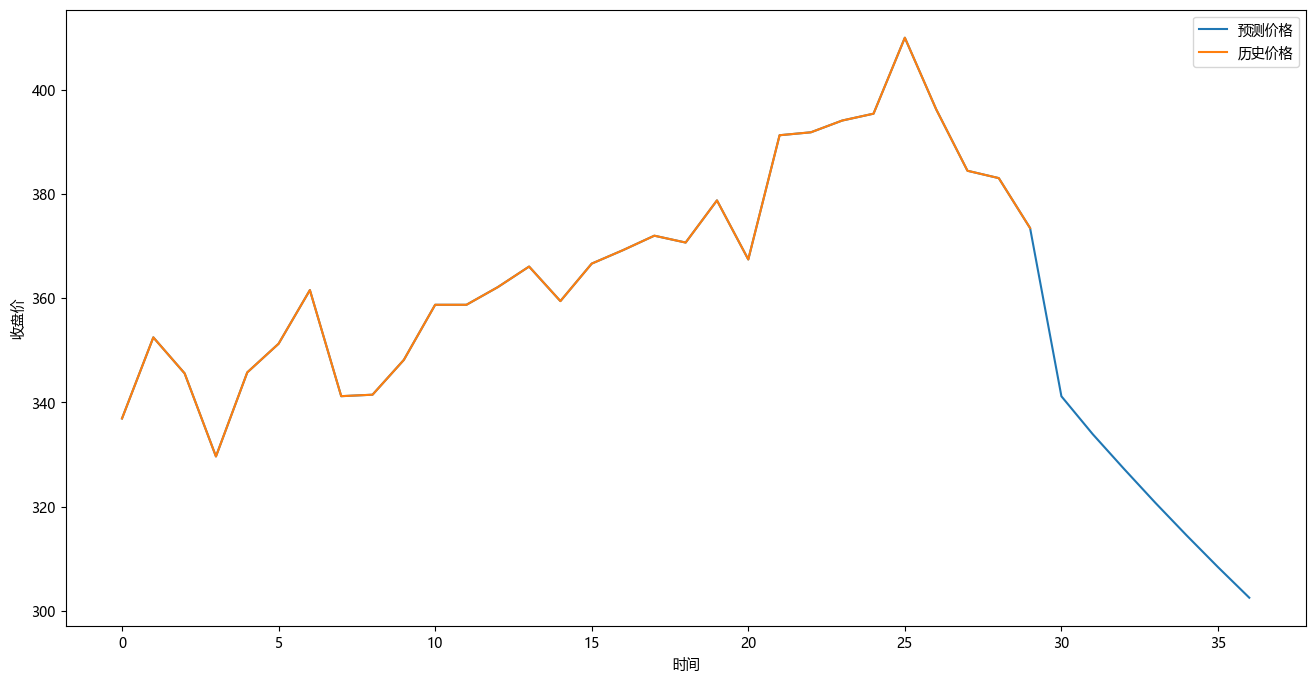

In [31]:
plt.rcParams['font.family'] = 'Microsoft YaHei'  # Microsoft YaHei, SimHei
plt.figure(figsize=(16, 8))
plt.plot(combined_array, label='预测价格')
plt.plot(AAPL_y_test[-30:], label='历史价格')
plt.xlabel('时间')
plt.ylabel('收盘价')
plt.legend()
plt.show()